In [ ]:
# Instalasi
!pip install transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.0
    Uninstalling fsspec-2025.5.0:
      Successfully uninstalled fsspec-2025.5.0


In [ ]:
import os
import re
import json
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from huggingface_hub import HfApi
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def clean_text(text):
    text = re.sub(r"http\S+", "", str(text))
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    return text.strip()

In [ ]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.3 MB/s eta 0:00:00


In [ ]:
df = pd.read_excel("/content/dataset.xlsx")
df['clean_text'] = df['full_text'].apply(clean_text)
df['label'] = df['label'].apply(lambda x: 1 if 'bot' in str(x).lower() else 0)

In [ ]:
df["created_at"] = pd.to_datetime(df["created_at"])
if df["created_at"].dt.tz is None:
    df["created_at"] = df["created_at"].dt.tz_localize("UTC")
df["created_at"] = df["created_at"].dt.tz_convert(None)

df["min_date"] = df.groupby("user_id_str")["created_at"].transform("min")
df["max_date"] = df.groupby("user_id_str")["created_at"].transform("max")
df["days_active"] = (df["max_date"] - df["min_date"]).dt.days + 1
df["tweet_count"] = df.groupby("user_id_str")["user_id_str"].transform("count")
df["tweet_per_day"] = df["tweet_count"] / df["days_active"]
df.drop(["min_date", "max_date", "days_active", "tweet_count"], axis=1, inplace=True)

<ipython-input-7-c11d22f594ea>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["created_at"] = pd.to_datetime(df["created_at"])


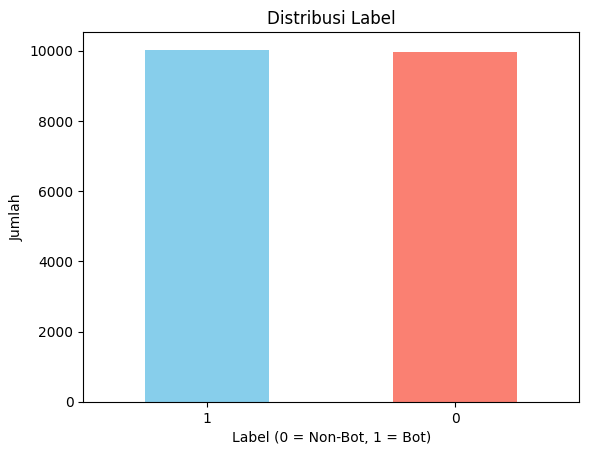

In [ ]:
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribusi Label')
plt.xlabel('Label (0 = Non-Bot, 1 = Bot)')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

In [ ]:
df.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,label,clean_text,tweet_per_day
0,1919363195979940096,2025-05-06 22:56:03,1,@Baktiar1772371 Beda jenis Bang. Kalo kucing h...,1919888921078449920,NaN,Baktiar1772371,in,NaN,0,0,0,https://x.com/turtle_arc/status/19198889210784...,1630888763852460032,turtle_arc,1,Beda jenis Bang. Kalo kucing hutan gedenya gak...,8.350877
1,1919775484776440064,2025-05-06 15:54:50,2,@GuarEmperor Siap direkrut masuk sirkel elite ...,1919782921155510016,NaN,GuarEmperor,in,NaN,0,0,0,https://x.com/turtle_arc/status/19197829211555...,1630888763852460032,turtle_arc,1,Siap direkrut masuk sirkel elite mas GE,8.350877
2,1919747559662490112,2025-05-06 15:20:32,0,@ooovgbnd Alhamdulillah masih dapet,1919774287340379904,NaN,ooovgbnd,in,NaN,0,0,0,https://x.com/turtle_arc/status/19197742873403...,1630888763852460032,turtle_arc,1,Alhamdulillah masih dapet,8.350877
3,1919735516687209984,2025-05-06 12:50:23,0,@satyaXBT pasti adalah.. carinya di resto khus...,1919736501673289984,NaN,satyaXBT,in,NaN,0,0,0,https://x.com/turtle_arc/status/19197365016732...,1630888763852460032,turtle_arc,1,pasti adalah.. carinya di resto khusus indo bi...,8.350877
4,1919735516687209984,2025-05-06 12:47:43,3,@satyaXBT gasss pindah negara dong ketuaa.. wk...,1919735828202589952,NaN,satyaXBT,in,NaN,0,1,0,https://x.com/turtle_arc/status/19197358282025...,1630888763852460032,turtle_arc,1,gasss pindah negara dong ketuaa.. wkwkwk,8.350877


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
MAX_LEN = 128

class TweetDataset(Dataset):
    def __init__(self, texts, numerical_features, labels):
        self.texts = texts
        self.numerical_features = numerical_features
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'numerical_features': torch.tensor(self.numerical_features[idx], dtype=torch.float),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Ambil fitur numerik yang akan dipakai
num_features = ["favorite_count", "retweet_count", "reply_count", "quote_count", "tweet_per_day"]

train_dataset = TweetDataset(
    train_df["clean_text"].tolist(),
    train_df[num_features].values,
    train_df["label"].tolist()
)
val_dataset = TweetDataset(
    val_df["clean_text"].tolist(),
    val_df[num_features].values,
    val_df["label"].tolist()
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
class IndoBERT_LSTM(nn.Module):
    def __init__(self, num_numerical_features):
        super(IndoBERT_LSTM, self).__init__()
        self.bert = AutoModel.from_pretrained("bert-base-multilingual-cased")
        self.lstm = nn.LSTM(self.bert.config.hidden_size, 128, batch_first=True)

        # Fully connected layers untuk fitur numerik
        self.num_fc = nn.Sequential(
            nn.Linear(num_numerical_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Gabungkan output LSTM dan fitur numerik
        self.classifier = nn.Linear(128 + 32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, numerical_features):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        _, (hidden, _) = self.lstm(bert_output)
        lstm_out = hidden[-1]

        num_out = self.num_fc(numerical_features)

        combined = torch.cat((lstm_out, num_out), dim=1)
        logits = self.classifier(combined)
        return self.sigmoid(logits)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
numeric_input_dim = 5
model = IndoBERT_LSTM(numeric_input_dim).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
from huggingface_hub import notebook_login
from huggingface_hub import notebook_login, Repository
from huggingface_hub import create_repo, upload_file
notebook_login()


In [ ]:
repo_id = "yazidsupriadi/mbert_lstm_bot"
local_dir = "mbert_lstm_bot"
os.makedirs(local_dir, exist_ok=True)
create_repo(repo_id, exist_ok=True)

RepoUrl('https://huggingface.co/yazidsupriadi/mbert_lstm_bot', endpoint='https://huggingface.co', repo_type='model', repo_id='yazidsupriadi/mbert_lstm_bot')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IndoBERT_LSTM(num_numerical_features=len(num_features)).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
log_file = os.path.join(local_dir, "training_log.md")
readme_file = os.path.join(local_dir, "README.md")

api = HfApi()

with open(log_file, "w") as f:
    f.write("# Training Log: IndoBERT + LSTM for Bot Detection\n\n")


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
from datetime import datetime
losses = []
val_accuracies = []
roc_aucs = []

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        numerical_features = batch["numerical_features"].to(device)
        labels = batch["labels"].to(device).float()

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, numerical_features).squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # VALIDASI
    model.eval()
    val_preds, val_probs, val_targets = [], [], []
    with torch.no_grad():
        for val_batch in val_loader:
            input_ids = val_batch["input_ids"].to(device)
            attention_mask = val_batch["attention_mask"].to(device)
            numerical_features = val_batch["numerical_features"].to(device)
            labels = val_batch["labels"].to(device)

            outputs = model(input_ids, attention_mask, numerical_features).squeeze()
            val_probs.extend(outputs.cpu().numpy())
            val_preds.extend((outputs > 0.5).int().cpu().numpy())
            val_targets.extend(labels.int().cpu().numpy())

    acc = accuracy_score(val_targets, val_preds)
    roc_auc = roc_auc_score(val_targets, val_probs)

    losses.append(total_loss / len(train_loader))
    val_accuracies.append(acc)
    roc_aucs.append(roc_auc)

    print(f"Epoch {epoch+1} - Loss: {losses[-1]:.4f} - Acc: {acc:.4f} - ROC AUC: {roc_auc:.4f}")

    # LOG
    with open(log_file, "a") as f:
        f.write(f"## Epoch {epoch+1} ({datetime.now().isoformat()})\n")
        f.write(f"- Train Loss: {losses[-1]:.4f}\n")
        f.write(f"- Validation Accuracy: {acc:.4f}\n")
        f.write(f"- ROC AUC Score: {roc_auc:.4f}\n\n")

    with open(log_file, "r") as src, open(readme_file, "w") as dst:
        dst.write(src.read())

    # SIMPAN MODEL
    model_path = os.path.join(local_dir, f"model_epoch_{epoch+1}.pt")
    torch.save(model.state_dict(), model_path)

    # UPLOAD KE HUGGING FACE
    api.upload_file(
        path_or_fileobj=model_path,
        path_in_repo=f"model_epoch_{epoch+1}.pt",
        repo_id=repo_id,
        repo_type="model"
    )
    api.upload_file(
        path_or_fileobj=log_file,
        path_in_repo="training_log.md",
        repo_id=repo_id,
        repo_type="model"
    )
    api.upload_file(
        path_or_fileobj=readme_file,
        path_in_repo="README.md",
        repo_id=repo_id,
        repo_type="model"
    )

print("✅ Training selesai dan model card berhasil diperbarui.")

Epoch 1: 100%|██████████| 1000/1000 [05:39<00:00,  2.95it/s]


Epoch 1 - Loss: 0.9218 - Acc: 0.8440 - ROC AUC: 0.9349


model_epoch_1.pt:   0%|          | 0.00/713M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9635: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
Epoch 2: 100%|██████████| 1000/1000 [05:37<00:00,  2.97it/s]


Epoch 2 - Loss: 0.3203 - Acc: 0.8642 - ROC AUC: 0.9492


model_epoch_2.pt:   0%|          | 0.00/713M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9635: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
Epoch 3: 100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Epoch 3 - Loss: 0.2937 - Acc: 0.8735 - ROC AUC: 0.9543


model_epoch_3.pt:   0%|          | 0.00/713M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9635: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
Epoch 4: 100%|██████████| 1000/1000 [05:37<00:00,  2.96it/s]


Epoch 4 - Loss: 0.2834 - Acc: 0.8802 - ROC AUC: 0.9578


model_epoch_4.pt:   0%|          | 0.00/713M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9635: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
Epoch 5: 100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]


Epoch 5 - Loss: 0.2710 - Acc: 0.8822 - ROC AUC: 0.9599


model_epoch_5.pt:   0%|          | 0.00/713M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9635: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
Epoch 6: 100%|██████████| 1000/1000 [05:33<00:00,  2.99it/s]


Epoch 6 - Loss: 0.2649 - Acc: 0.8872 - ROC AUC: 0.9623


model_epoch_6.pt:   0%|          | 0.00/713M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9635: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
Epoch 7: 100%|██████████| 1000/1000 [05:37<00:00,  2.96it/s]


Epoch 7 - Loss: 0.2584 - Acc: 0.8895 - ROC AUC: 0.9640


model_epoch_7.pt:   0%|          | 0.00/713M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9635: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
Epoch 8: 100%|██████████| 1000/1000 [05:34<00:00,  2.99it/s]


Epoch 8 - Loss: 0.2542 - Acc: 0.8900 - ROC AUC: 0.9654


model_epoch_8.pt:   0%|          | 0.00/713M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9635: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
Epoch 9: 100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]


Epoch 9 - Loss: 0.2509 - Acc: 0.8918 - ROC AUC: 0.9660


model_epoch_9.pt:   0%|          | 0.00/713M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9635: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
Epoch 10: 100%|██████████| 1000/1000 [05:31<00:00,  3.02it/s]


Epoch 10 - Loss: 0.2457 - Acc: 0.8905 - ROC AUC: 0.9666


model_epoch_10.pt:   0%|          | 0.00/713M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9635: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


✅ Training selesai dan model card berhasil diperbarui.


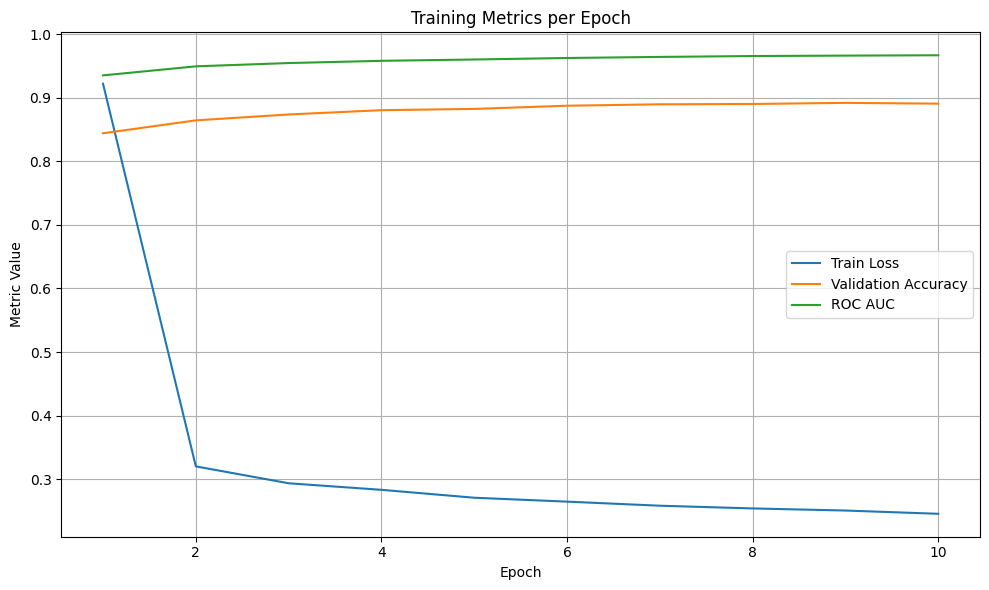

✅ Training dan upload ke Hugging Face selesai.


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1, EPOCHS+1), losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_accuracies, label="Validation Accuracy")
plt.plot(range(1, EPOCHS+1), roc_aucs, label="ROC AUC")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Training Metrics per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plot_path = os.path.join(local_dir, "training_metrics.png")
plt.savefig(plot_path)
plt.show()

api.upload_file(
    path_or_fileobj=plot_path,
    path_in_repo="training_metrics.png",
    repo_id=repo_id,
    repo_type="model"
)

print("✅ Training dan upload ke Hugging Face selesai.")

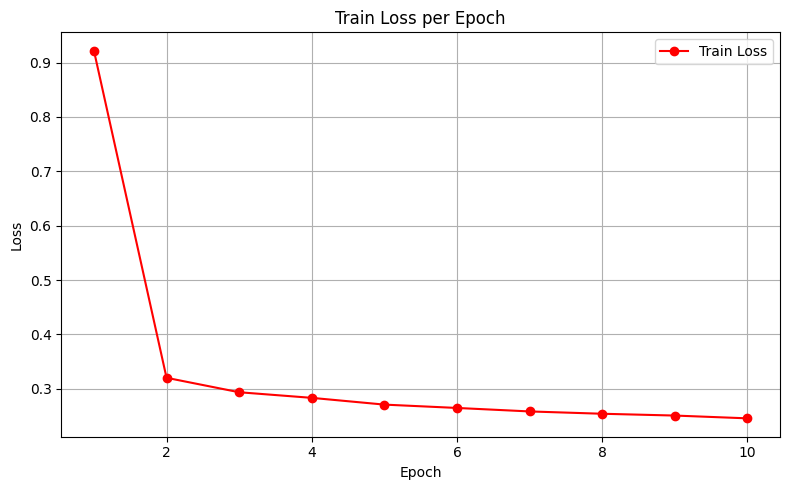

CommitInfo(commit_url='https://huggingface.co/yazidsupriadi/mbert_lstm_bot/commit/e3e18002432de167067cec72bbb1874c79e227e8', commit_message='Upload loss_per_epoch.png with huggingface_hub', commit_description='', oid='e3e18002432de167067cec72bbb1874c79e227e8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yazidsupriadi/mbert_lstm_bot', endpoint='https://huggingface.co', repo_type='model', repo_id='yazidsupriadi/mbert_lstm_bot'), pr_revision=None, pr_num=None)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS+1), losses, marker='o', label='Train Loss', color='red')
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
loss_plot_path = os.path.join(local_dir, "loss_per_epoch.png")
plt.savefig(loss_plot_path)
plt.show()
api.upload_file(
    path_or_fileobj=loss_plot_path,
    path_in_repo="loss_per_epoch.png",
    repo_id=repo_id,
    repo_type="model"
)

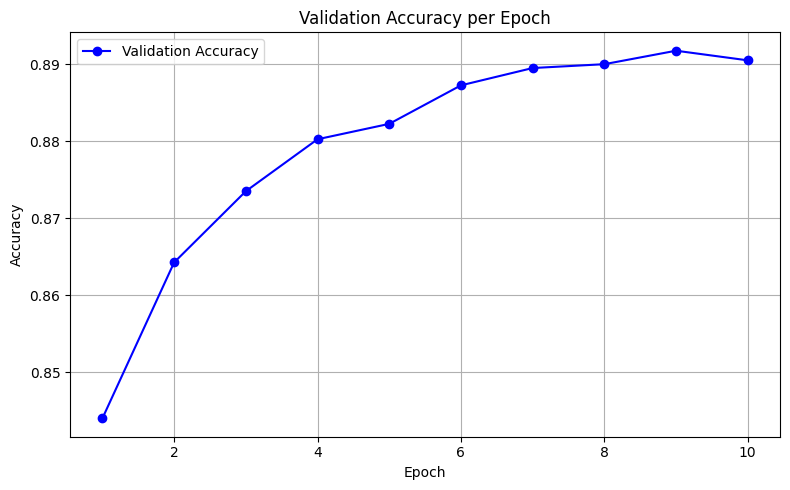

CommitInfo(commit_url='https://huggingface.co/yazidsupriadi/mbert_lstm_bot/commit/9428c9afb776b08d7d74a8dc76d7a72bf6eee179', commit_message='Upload accuracy_per_epoch.png with huggingface_hub', commit_description='', oid='9428c9afb776b08d7d74a8dc76d7a72bf6eee179', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yazidsupriadi/mbert_lstm_bot', endpoint='https://huggingface.co', repo_type='model', repo_id='yazidsupriadi/mbert_lstm_bot'), pr_revision=None, pr_num=None)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS+1), val_accuracies, marker='o', label='Validation Accuracy', color='blue')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
acc_plot_path = os.path.join(local_dir, "accuracy_per_epoch.png")
plt.savefig(acc_plot_path)
plt.show()

api.upload_file(
    path_or_fileobj=acc_plot_path,
    path_in_repo="accuracy_per_epoch.png",
    repo_id=repo_id,
    repo_type="model"
)

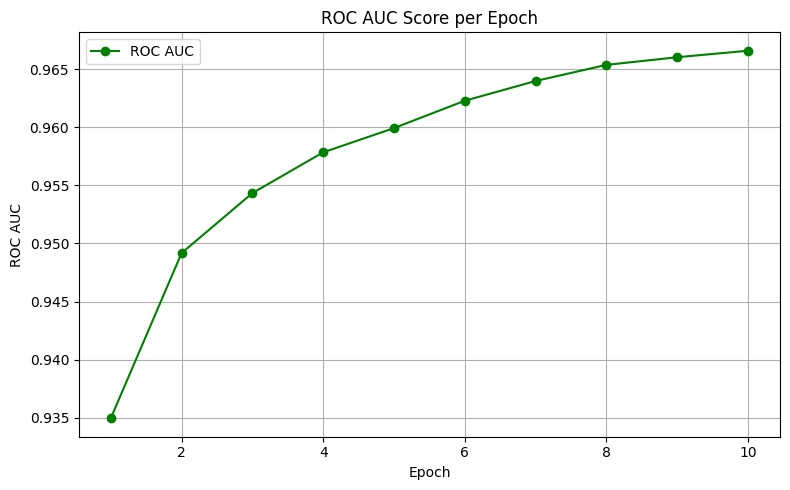

CommitInfo(commit_url='https://huggingface.co/yazidsupriadi/mbert_lstm_bot/commit/390cf9c59e3e6812552cb0dbc1a4ee89a3d669f2', commit_message='Upload roc_auc_per_epoch.png with huggingface_hub', commit_description='', oid='390cf9c59e3e6812552cb0dbc1a4ee89a3d669f2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yazidsupriadi/mbert_lstm_bot', endpoint='https://huggingface.co', repo_type='model', repo_id='yazidsupriadi/mbert_lstm_bot'), pr_revision=None, pr_num=None)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS+1), roc_aucs, marker='o', label='ROC AUC', color='green')
plt.title("ROC AUC Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.grid(True)
plt.legend()
plt.tight_layout()
roc_plot_path = os.path.join(local_dir, "roc_auc_per_epoch.png")
plt.savefig(roc_plot_path)
plt.show()

api.upload_file(
    path_or_fileobj=roc_plot_path,
    path_in_repo="roc_auc_per_epoch.png",
    repo_id=repo_id,
    repo_type="model"
)

In [ ]:
from sklearn.metrics import classification_report

print("📄 Classification Report:")
print(classification_report(val_targets, val_preds, target_names=["Manusia", "Bot"]))

📄 Classification Report:
              precision    recall  f1-score   support

     Manusia       0.88      0.90      0.89      1994
         Bot       0.90      0.88      0.89      2006

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



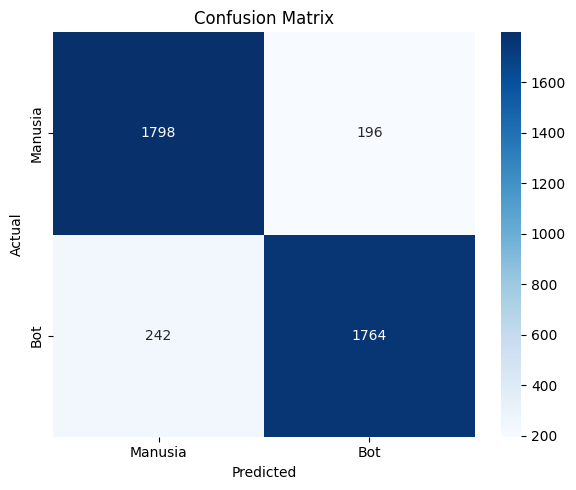

CommitInfo(commit_url='https://huggingface.co/yazidsupriadi/mbert_lstm_bot/commit/911dfb1288f12c445b29db742f115767fbc2ed66', commit_message='Upload confusion_matrix.png with huggingface_hub', commit_description='', oid='911dfb1288f12c445b29db742f115767fbc2ed66', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yazidsupriadi/mbert_lstm_bot', endpoint='https://huggingface.co', repo_type='model', repo_id='yazidsupriadi/mbert_lstm_bot'), pr_revision=None, pr_num=None)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(val_targets, val_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Manusia", "Bot"], yticklabels=["Manusia", "Bot"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
cm_plot_path = os.path.join(local_dir, "confusion_matrix.png")
plt.savefig(cm_plot_path)
plt.show()

# Upload ke Hugging Face
api.upload_file(
    path_or_fileobj=cm_plot_path,
    path_in_repo="confusion_matrix.png",
    repo_id=repo_id,
    repo_type="model"
)

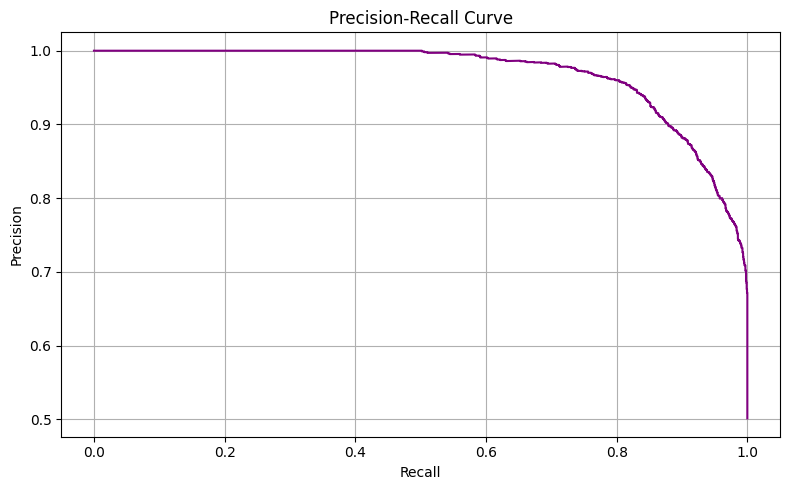

CommitInfo(commit_url='https://huggingface.co/yazidsupriadi/mbert_lstm_bot/commit/17db178dcf56756484f231fc59c2be8043094711', commit_message='Upload precision_recall_curve.png with huggingface_hub', commit_description='', oid='17db178dcf56756484f231fc59c2be8043094711', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yazidsupriadi/mbert_lstm_bot', endpoint='https://huggingface.co', repo_type='model', repo_id='yazidsupriadi/mbert_lstm_bot'), pr_revision=None, pr_num=None)

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(val_targets, val_probs)

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
pr_plot_path = os.path.join(local_dir, "precision_recall_curve.png")
plt.savefig(pr_plot_path)
plt.show()

# Upload ke HF
api.upload_file(
    path_or_fileobj=pr_plot_path,
    path_in_repo="precision_recall_curve.png",
    repo_id=repo_id,
    repo_type="model"
)
